# 1. UNDERSTAND THE BUSINESS CASE

Predictive models attempt at forecasting future sales based on historical data while taking into account seasonality effects, demand, holidays, promotions, and competition.

In this project, we work as data scientists in the sales department and the sales team provided you with data from 1115 stores. The objective is to predict future daily sales based on the features. 

**INPUTS AND EXPECTED OUTPUT**

- Id: transaction ID (combination of Store and date)
- Store: unique store Id
- Sales: sales/day, this is the target variable 
- Customers: number of customers on a given day
- Open: Boolean to say whether a store is open or closed (0 = closed, 1 = open)
- Promo: describes if store is running a promo on   that day or not
- StateHoliday: indicate which state holiday (a = public holiday, b = Easter holiday, c = Christmas, 0 = None)
- SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
- StoreType: categorical variable to indicate type of store (a, b, c, d)
- Assortment:  a = basic, b = extra, c = extended
- CompetitionDistance (meters): distance to closest competitor store
- CompetitionOpenSince [Month/Year]:  date when competition was open
- Promo2: Promo2 is a continuing and consecutive promotion for some stores (0 = store is not participating, 1 = store is participating)
- Promo2Since [Year/Week]: date when store started participating in Promo2
- PromoInterval: describes the consecutive intervals Promo2 is started, naming the months promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

# 2. EXPLORE DATASET

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import datetime
import seaborn as sns

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')


In [3]:
# train = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales forecasting/train.csv')
train = pd.read_csv("train.csv")
train.head()

/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/1134450754.py:3: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train = pd.read_csv("train.csv")


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB


There are almost a million observation, 1115 unique stores 
Note that sales is the target variable (that's what we are trying to predict) 

In [6]:
pd.set_option('display.max_colwidth', None)
train.describe()

,Store,DayOfWeek,Sales,Customers,Open,Promo,SchoolHoliday
count,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06,1.017209e+06
mean,5.584297e+02,3.998341e+00,5.773819e+03,6.331459e+02,8.301067e-01,3.815145e-01,1.786467e-01
std,3.219087e+02,1.997391e+00,3.849926e+03,4.644117e+02,3.755392e-01,4.857586e-01,3.830564e-01
min,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.800000e+02,2.000000e+00,3.727000e+03,4.050000e+02,1.000000e+00,0.000000e+00,0.000000e+00
50%,5.580000e+02,4.000000e+00,5.744000e+03,6.090000e+02,1.000000e+00,0.000000e+00,0.000000e+00
75%,8.380000e+02,6.000000e+00,7.856000e+03,8.370000e+02,1.000000e+00,1.000000e+00,0.000000e+00
max,1.115000e+03,7.000000e+00,4.155100e+04,7.388000e+03,1.000000e+00,1.000000e+00,1.000000e+00


- Average sales amount per day = 5773 Euros, 
- Average 600 customers per day, maximum is 4500,
- minimum sales per day = 0, 
- maximum sales per day = 41551 
- Average number of customers = 633, 
- minimum number of customers = 0, 
- maximum number of customers = 7388

In [8]:
# store = pd.read_csv('/content/drive/My Drive/Colab Notebooks/sales forecasting/store.csv')
store = pd.read_csv("store.csv")
store.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [9]:
store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1115 entries, 0 to 1114
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Store                      1115 non-null   int64  
 1   StoreType                  1115 non-null   object 
 2   Assortment                 1115 non-null   object 
 3   CompetitionDistance        1112 non-null   float64
 4   CompetitionOpenSinceMonth  761 non-null    float64
 5   CompetitionOpenSinceYear   761 non-null    float64
 6   Promo2                     1115 non-null   int64  
 7   Promo2SinceWeek            571 non-null    float64
 8   Promo2SinceYear            571 non-null    float64
 9   PromoInterval              571 non-null    object 
dtypes: float64(5), int64(2), object(3)
memory usage: 87.2+ KB


Note that the previous dataframe includes the transactions recorded per day (in millions). Store dataframe only includes information about the unique 1115 stores that are part of this study 

In [10]:
store.describe()

,Store,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear
count,1115.00000,1112.000000,761.000000,761.000000,1115.000000,571.000000,571.000000
mean,558.00000,5404.901079,7.224704,2008.668857,0.512108,23.595447,2011.763573
std,322.01708,7663.174720,3.212348,6.195983,0.500078,14.141984,1.674935
min,1.00000,20.000000,1.000000,1900.000000,0.000000,1.000000,2009.000000
25%,279.50000,717.500000,4.000000,2006.000000,0.000000,13.000000,2011.000000
50%,558.00000,2325.000000,8.000000,2010.000000,1.000000,22.000000,2012.000000
75%,836.50000,6882.500000,10.000000,2013.000000,1.000000,37.000000,2013.000000
max,1115.00000,75860.000000,12.000000,2015.000000,1.000000,50.000000,2015.000000


On average, the competition distance is 5404 meters away (5.4 kms)

EXPLORE SALES TRAINING DATA

Let's see if we have any missing data, luckily we don't!


In [12]:
train.isnull().sum()

Store            0
DayOfWeek        0
Date             0
Sales            0
Customers        0
Open             0
Promo            0
StateHoliday     0
SchoolHoliday    0
dtype: int64

/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/usr/local/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


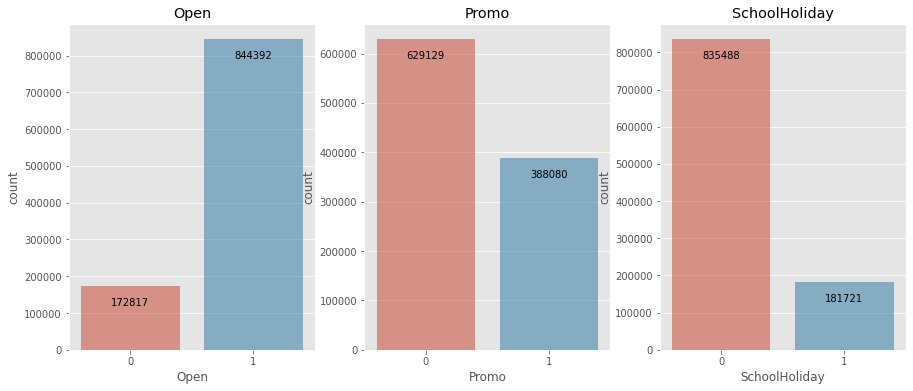

In [44]:
def _plot_numeric_classes(df, col):
    ax = sns.countplot(df[col], alpha = 0.6)
    for p in ax.patches:
        ax.annotate(f'\n{p.get_height()}', (p.get_x()+0.4, p.get_height()), ha='center', va='top', size=10)

def _distribution_numeric(df, numeric_cols, row=1, col=3, figsize=(15, 6)):
    assert row*(col-1) < len(numeric_cols)
    plt.figure(figsize = figsize)
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.2, hspace=0.5)
    for i in range(1, len(numeric_cols)+1, 1):
      try:
        plt.subplot(row, col, i)
        _plot_numeric_classes(df, numeric_cols[i-1])
        plt.title(numeric_cols[i-1])
      except:
        print('Error {}'.format(numeric_cols[i-1]))
        break
plt.style.use("ggplot")
numeric_cols = ['Open', 'Promo', 'SchoolHoliday']
_distribution_numeric(train, numeric_cols)

There are 844k stores openning, 172k are closed.

Promo was running ~40% of the time 

School holidays are around ~18% of the time

In [35]:
# only keep open stores and remove closed stores
# drop the open column since it has no meaning nbarplot
train1 = train[train["Open"] == 1]
train1.drop(columns = "Open", inplace = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 844392 entries, 0 to 1017190
Data columns (total 9 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Store          844392 non-null  int64 
 1   DayOfWeek      844392 non-null  int64 
 2   Date           844392 non-null  object
 3   Sales          844392 non-null  int64 
 4   Customers      844392 non-null  int64 
 5   Open           844392 non-null  int64 
 6   Promo          844392 non-null  int64 
 7   StateHoliday   844392 non-null  object
 8   SchoolHoliday  844392 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 64.4+ MB


<AxesSubplot:xlabel='Sales', ylabel='Count'>

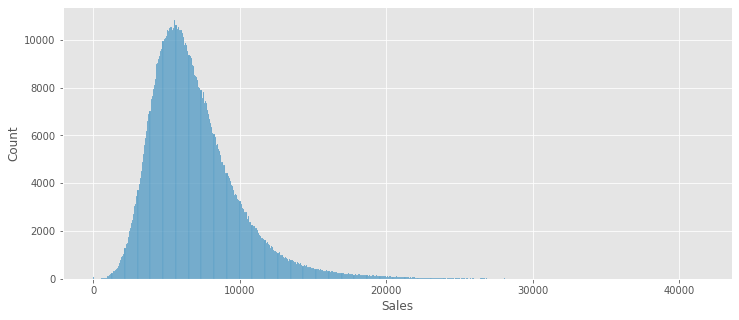

In [60]:
#Sales
plt.figure(figsize=(12,5))
sns.histplot(train1["Sales"])

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

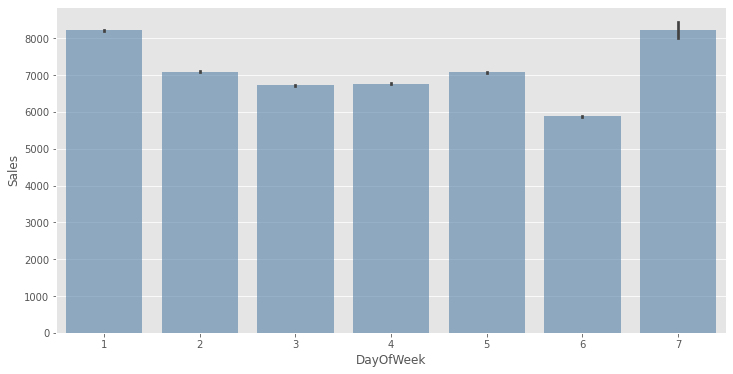

In [96]:
#week distribtuion
plt.figure(figsize=(12,6))
sns.barplot(x = train1["DayOfWeek"], y = train1["Sales"],  color='#4682B4', alpha = 0.6)

Data is distibuted pretty equally across various Days of the week

Data is equally distributed among all stores (no bias)

/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/1794216918.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train1["Date"] = pd.to_datetime(train1["Date"])


Text(0.5, 1.0, 'Store 800')

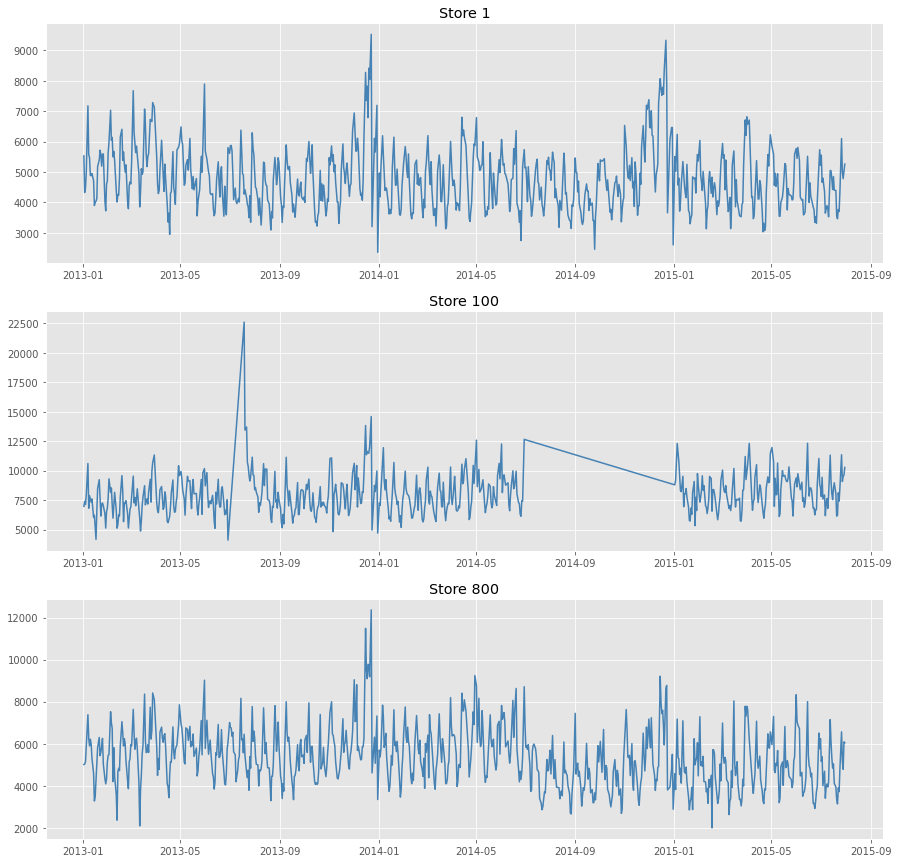

In [94]:
train1["Date"] = pd.to_datetime(train1["Date"])
store1 = train1[train1["Store"] == 1]
store100 = train1[train1["Store"] == 100]
store800 = train1[train1["Store"] == 800]
plt.figure(figsize=(15,15))
plt.subplot(3,1,1)
plt.plot(store1["Date"], store1['Sales'], color='#4682B4')
plt.title('Store 1')
plt.subplot(3,1,2)
plt.plot(store100["Date"], store100['Sales'], color='#4682B4')
plt.title('Store 100')
plt.subplot(3,1,3)
plt.plot(store800["Date"], store800['Sales'], color='#4682B4')
plt.title('Store 800')

A quick view on time series of store 1, 100, 800. Sales volume fluctuate every month and seem to have a constant mean. No increasing trend or decreasing trend is observed. 

Store 800 appears to be a white noise. Both 3 store have a huge spikes on Jan 2014 and Dec 2015, which is Christmas, New year holiday. Store 2 has a huge spike on Aug 2013. 

EXPLORE STORES INFORMATION DATA

In [43]:
# Check missing data in the store dataframe.
store.isna().sum()

Store                          0
StoreType                      0
Assortment                     0
CompetitionDistance            3
CompetitionOpenSinceMonth    354
CompetitionOpenSinceYear     354
Promo2                         0
Promo2SinceWeek              544
Promo2SinceYear              544
PromoInterval                544
dtype: int64


CompetitionOpen are missing 354, And promo2 time missing 544, half of data. We can remove these variable. 

In [98]:
store1 = store[["Store", "StoreType", "Assortment","CompetitionDistance", "Promo2"]]

CompetitionDistance has 3 missing value, very small number comparing to total, let's fill the mean value for these 3 missing. 

In [110]:
store1.fillna(store1.mean(), inplace=True)

/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/4121141835.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  store1.fillna(store1.mean(), inplace=True)
/var/folders/23/9f15z0c11jz_sy9hlr5w468h0000gn/T/ipykernel_11958/4121141835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  store1.fillna(store1.mean(), inplace=True)


MERGED DATASET 

In [118]:
# Let's merge both data frames together based on 'store'
df = pd.merge(train1, store1, on='Store')
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,Promo2
0,1,5,2015-07-31,5263,555,1,0,1,c,a,1270.0,0
1,1,4,2015-07-30,5020,546,1,0,1,c,a,1270.0,0
2,1,3,2015-07-29,4782,523,1,0,1,c,a,1270.0,0
3,1,2,2015-07-28,5011,560,1,0,1,c,a,1270.0,0
4,1,1,2015-07-27,6102,612,1,0,1,c,a,1270.0,0


<AxesSubplot:>

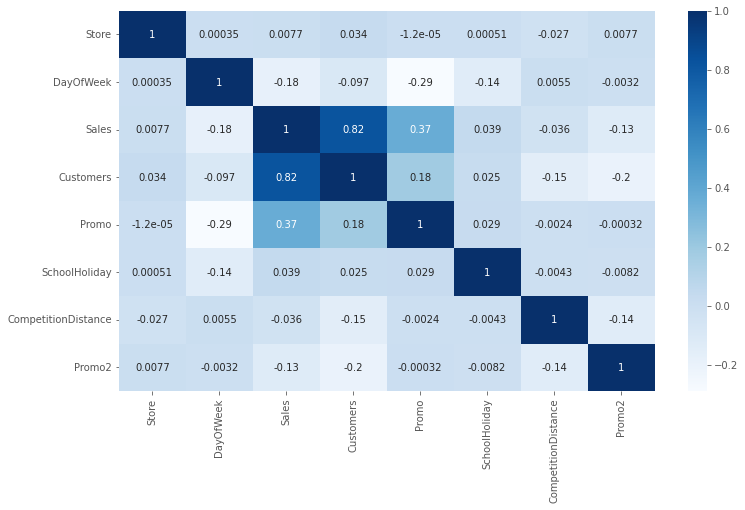

In [120]:
plt.figure(figsize=(12,7))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='Blues')


`Customers` and `Promo` are strongly correlated to `sales`. `Promo2` does not seem to be effective at all 

In [121]:
# Let's  separate the year, Day and Month
df['Year'] = pd.DatetimeIndex(df['Date']).year
df['Month'] = pd.DatetimeIndex(df['Date']).month
df['Day'] = pd.DatetimeIndex(df['Date']).day

In [ ]:
# Let's take a look at the average sales and number of customers per month 
# 'groupby' works great by grouping all the data that share the same month column, then obtain the mean of the sales column  
# It looks like sales and number of customers peak around christmas timeframe



In [ ]:
# Let's take a look at the sales and customers per day of the month instead
# Minimum number of customers are generally around the 24th of the month 
# Most customers and sales are around 30th and 1st of the month



In [ ]:
# Let's do the same for the day of the week  (note that 7 = Sunday)



# TASK #4: UNDERSTAND THE INTUITION BEHIND FACEBOOK PROPHET

![alt text](https://drive.google.com/uc?id=1I4lBgLaqERF_-lpGYLuht02wJmwcLGG-)

![alt text](https://drive.google.com/uc?id=1CZ24f-TbnRzaXV9Arke0fNTUm7Kon1gK)

![alt text](https://drive.google.com/uc?id=16gaoTeeuU5PxNZRHt8n2XyFJ52ft1xb7)

# TASK #5: TRAIN THE MODEL PART A

In [ ]:
# import prophet 

# TASK #6: TRAIN THE MODEL PART B


   - StateHoliday: indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
   - SchoolHoliday: indicates if the (Store, Date) was affected by the closure of public schools
  






In [ ]:
# Get all the dates pertaining to school holidays 


In [ ]:
# Get all the dates pertaining to state holidays 


In [ ]:
# concatenate both school and state holidays 


In [ ]:
# Let's make predictions using holidays for a specific store


# EXCELLENT JOB!